1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
 
2. (\*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [3]:
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=42)

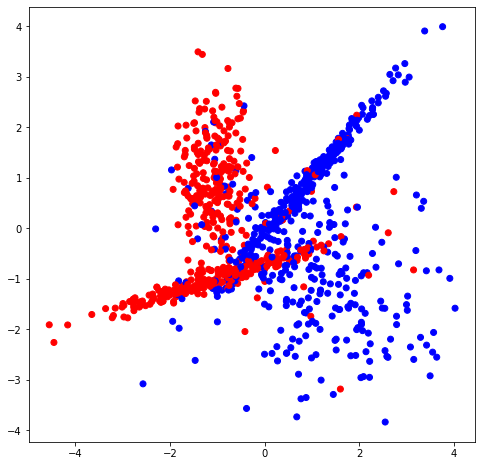

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors);

In [5]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    full_indices = range(n_samples)
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_indices = set()  # сохраняем индексы, используемые для дерева
        
        for j in full_indices:
            sample_index = random.randint(0, n_samples-1)
            b_indices.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        # сохраняем не вошедшие в bootstrap индексы для OOB метода
        bootstrap.append((b_data, b_labels, np.setdiff1d(full_indices, list(b_indices))))
    return bootstrap

In [6]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, b_OOB in bootstrap:
        forest.append((build_tree(b_data, b_labels), b_OOB))
        
    return forest

In [15]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree, b_oob in forest:
            predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
def OOB_error(forest, data, labels):
    correct, OOB_count = 0, 0
    n_samples = data.shape[0]
    for i in range(n_samples):
        predictions = []
        for tree, OOB_inds in forest:
            if i in OOB_inds:  # если объект не участвовал в обучении дерева
                predictions.append(classify_object(data[i], tree))
        
        if len(predictions) > 0:  # если объект попал в общую Out-of-bag выборку
            mean_pred = round(np.mean(predictions))
            OOB_count += 1  # подсчитываем размер общей Out-of-bag выборки
            if labels[i] == mean_pred:
                correct += 1
    
    return correct / float(OOB_count) * 100.0, OOB_count

In [20]:
def OOB_error_2(forest, data, labels):
    # 2й вариант: усредняем ошибку по прогнозам от каждого дерева на не использованных в его обучении объектах
    # оценка, по идее, должна быть грубее 1го варианта...
    metrics = []
    for tree, OOB_ind in forest:
        metrics.append(accuracy_metric(labels[OOB_ind], predict(data[OOB_ind], tree)))
    return np.mean(metrics)

In [21]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 42)

In [22]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

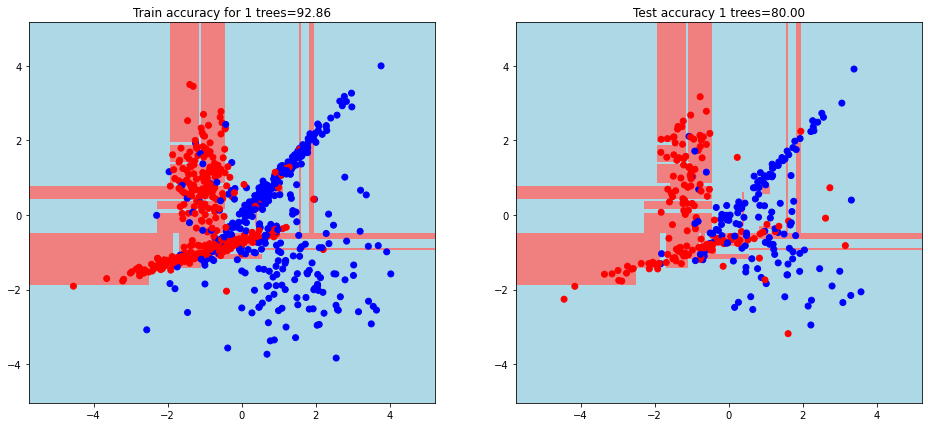

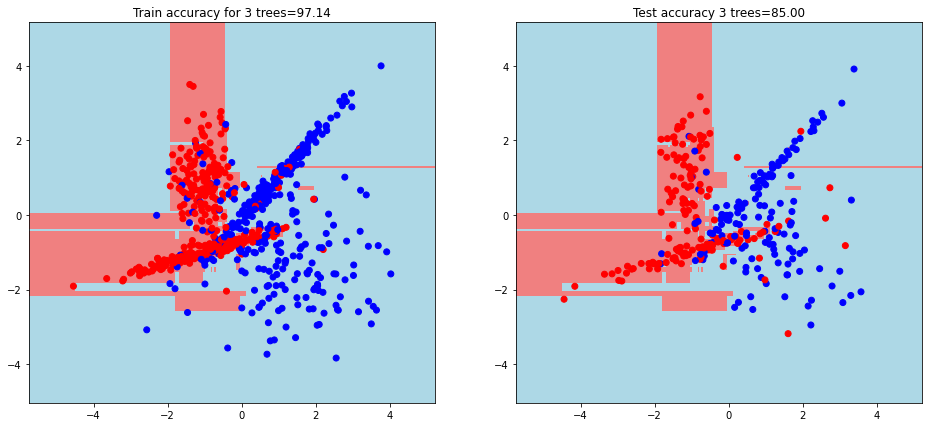

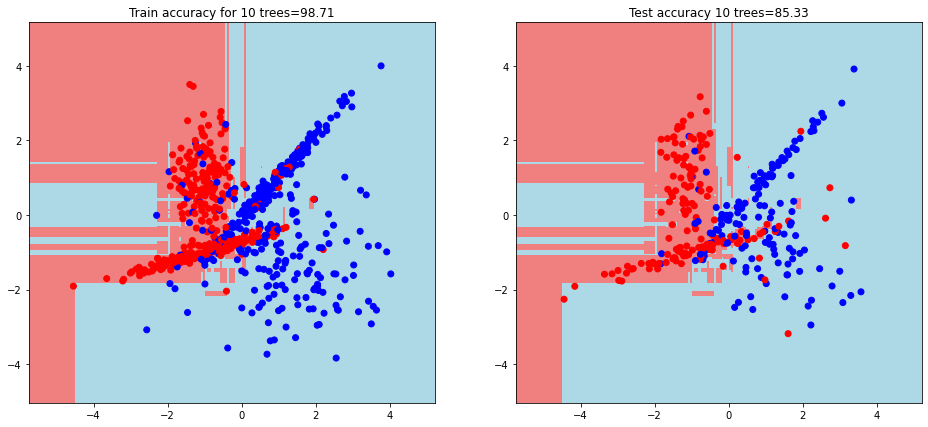

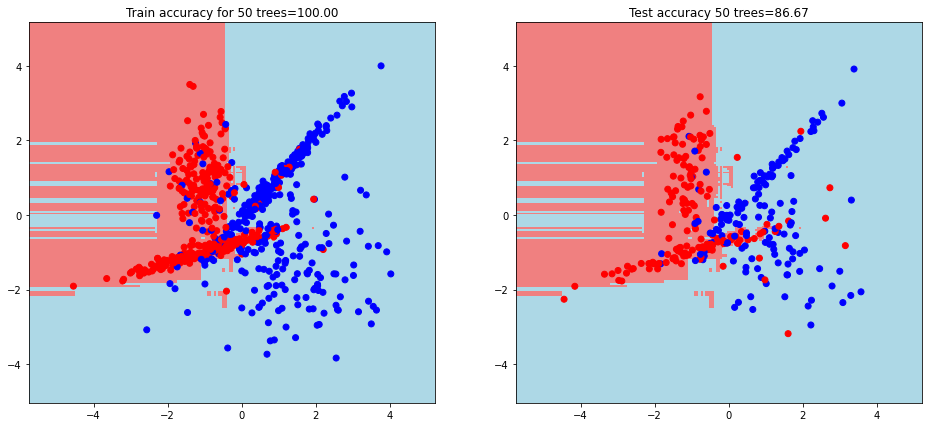

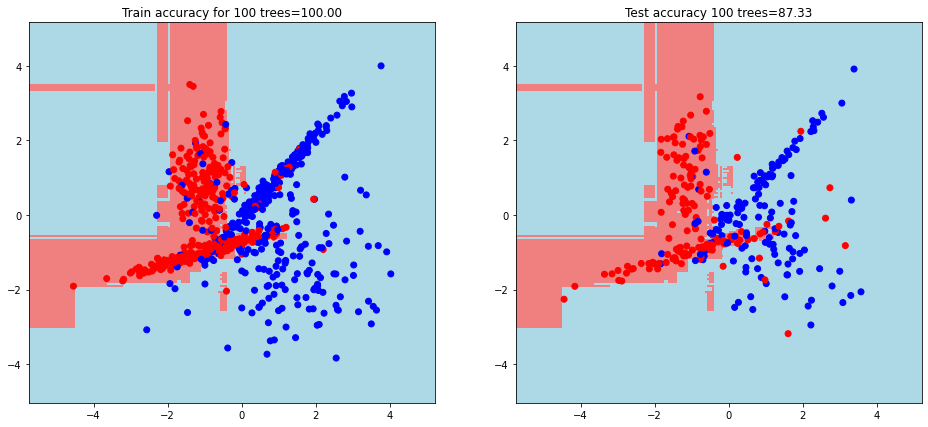

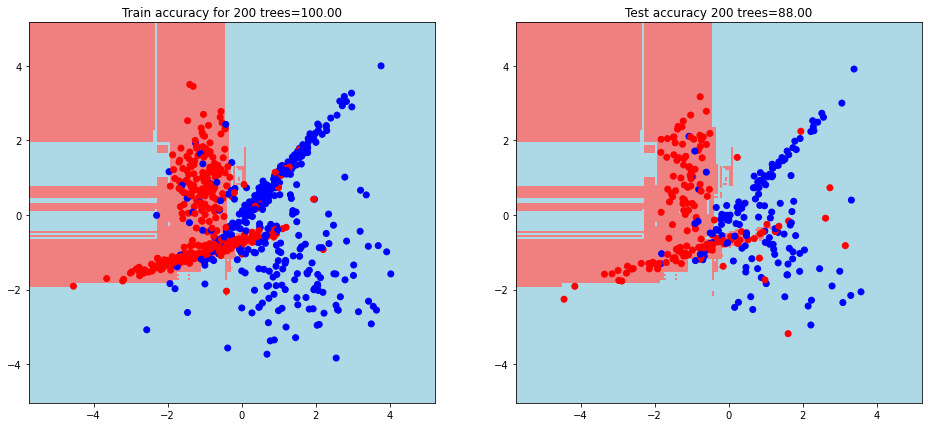

In [23]:
n_trees = [1, 3, 10, 50, 100, 200]
train_accs, test_accs, OOB_accs, OOB2_accs = [], [], [], []
for n in n_trees:
    forest = random_forest(train_data, train_labels, n)
    
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(forest, train_data)
    
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(forest, test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    train_accs.append(train_accuracy)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    test_accs.append(test_accuracy)
    OOB_accs.append(OOB_error(forest, train_data, train_labels))
    OOB2_accs.append(OOB_error_2(forest, train_data, train_labels))
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy for {n} trees={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy {n} trees={test_accuracy:.2f}')

([92.85714285714286,
  97.14285714285714,
  98.71428571428571,
  100.0,
  100.0,
  100.0],
 [80.0, 85.0, 85.33333333333334, 86.66666666666667, 87.33333333333333, 88.0],
 [(80.54474708171206, 257),
  (82.36397748592871, 533),
  (85.26011560693641, 692),
  (86.42857142857143, 700),
  (87.85714285714286, 700),
  (87.71428571428571, 700)],
 [80.54474708171206,
  82.55408549302531,
  82.53108616272306,
  81.54487458563807,
  81.87805573640706,
  81.53385848560883])

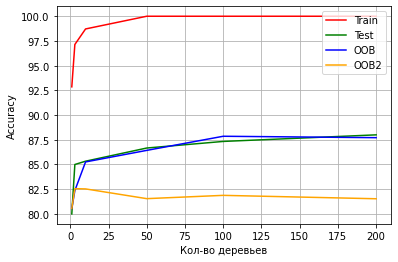

In [27]:
plt.plot(n_trees, train_accs, 'r', label='Train')
plt.plot(n_trees, test_accs, 'g', label='Test')
plt.plot(n_trees, np.asarray(OOB_accs)[:,0], 'b', label='OOB')
plt.plot(n_trees, OOB2_accs, 'orange', label='OOB2')

plt.xlabel('Кол-во деревьев')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();

train_accs, test_accs, OOB_accs, OOB2_accs

**Выводы:** при увеличении кол-ва деревьев в лесе границы деления становятся более точечными и менее разорванными ("сглаженными"). Также увеличивается качество прогнозирования, что видно как по общей метрике по лесу, так и по OOB-ошибке (второй вариант расчёта OOB оказался грубым и не информативным - но про него пишут в интернете =) "Можно оценить ошибку с помощью полученных  OOB-ответов, но чаще делают проще: для каждого базового алгоритма ошибку оценивают на объектах, не попавших в его обучение, а затем ошибки усредняют."). При этом переобучения не наблюдается - ошибка не начинает становиться меньше при увеличении кол-ва деревьев.